# Week 5
## Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Rock Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Rock Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into Section 9.4 in the exercises below. We will also talk a little bit about degree correlations - you can read about those in **Chapter 7**.

In [1]:
# the network from week 4
import os
import re
import networkx as nx

# -----------------------
# Sanitize performer names like Part 1
# -----------------------
def sanitize_filename(name):
    """Replace characters invalid in Windows filenames with underscore."""
    # Replace spaces and invalid characters with _
    return re.sub(r'[<>:"/\\|?* ]', '_', name)

# -----------------------
# Step 1: Load performers from folder
# -----------------------
data_dir = "rock_artists_pages"
performer_files = sorted(os.listdir(data_dir))

# Use sanitized filenames as performer identifiers
performer_set = set([os.path.splitext(f)[0] for f in performer_files])
performer_names = sorted(performer_set)

print(f"Found {len(performer_names)} performer pages.")

# -------------------------------
# Step 2: Function to extract links
# -------------------------------
def extract_links_from_page(text):
    """
    Extract links to other performers from Wikipedia page text.
    Links are in the form [[Artist]] or [[Artist|Label]].
    Only keep links that are in performer_set.
    """
    pattern = re.compile(r"\[\[([^\]]+)\]\]")  # [[Artist]] or [[Artist|Label]]
    links = []
    for match in pattern.finditer(text):
        inner = match.group(1).strip()

        # Take the left side if there's a pipe
        artist_page = inner.split("|")[0].strip()

        # Sanitize like Part 1 (spaces and invalid chars → _)
        artist_page = sanitize_filename(artist_page)

        links.append(artist_page)
    return links

# ------------------------
# Step 3: Build the network
# ------------------------
G = nx.DiGraph()

for idx, performer_name in enumerate(performer_names, 1):
    print(f"[{idx}/{len(performer_names)}] Processing: {performer_name}")

    file_path = os.path.join(data_dir, f"{performer_name}.txt")
    if not os.path.exists(file_path):
        print(f"  -> Missing page: {performer_name}")
        continue

    with open(file_path, encoding="utf-8") as f:
        text = f.read()

    # Count length of content
    char_len = len(text)

    # Add performer node, length_of_content attribute
    G.add_node(performer_name, length_of_content=char_len)

    # Extract links and add edges
    links = extract_links_from_page(text)

    # Filter only performers
    valid_links = [target for target in links if target in performer_set]

    # Debug: only print performer links for the first page
    if idx == 1:
        print("DEBUG - Performer links (sanitized):", valid_links)

    # Add edges
    edge_count = 0
    for target in valid_links:
        G.add_edge(performer_name, target)
        edge_count += 1
    print(f"  -> Added {edge_count} edges")

# ----------------------------------
# Step 4: Remove isolated performers
# ----------------------------------
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
print(f"Removed {len(isolated)} isolated performers.")

# ----------------------------------------------------
# Step 5: Keep only the largest weakly connected component
# ----------------------------------------------------
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

print(f"Final network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Found 488 performer pages.
[1/488] Processing: 10_Years_(band)
DEBUG - Performer links (sanitized): ['Disturbed_(band)', 'Breaking_Benjamin', 'Mudvayne', 'Korn', 'Deftones', 'Stone_Temple_Pilots', 'Thousand_Foot_Krutch', 'Linkin_Park', 'Shinedown', 'Puddle_of_Mudd', 'Breaking_Benjamin']
  -> Added 11 edges
[2/488] Processing: 10cc
  -> Added 24 edges
[3/488] Processing: 311_(band)
  -> Added 23 edges
[4/488] Processing: 38_Special_(band)
  -> Added 17 edges
[5/488] Processing: 3_Doors_Down
  -> Added 15 edges
[6/488] Processing: ABBA
  -> Added 13 edges
[7/488] Processing: AC_DC
  -> Added 30 edges
[8/488] Processing: AFI_(band)
  -> Added 10 edges
[9/488] Processing: A_Perfect_Circle
  -> Added 22 edges
[10/488] Processing: Accept_(band)
  -> Added 20 edges
[11/488] Processing: Adam_Ant
  -> Added 12 edges
[12/488] Processing: Aerosmith
  -> Added 62 edges
[13/488] Processing: Air_Supply
  -> Added 3 edges
[14/488] Processing: Alanis_Morissette
  -> Added 23 edges
[15/488] Processing:

# Part A: Let's  visualise some more!

For the rest of the course, we will primarily use[`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679), a layout algorithm which was developed by the creators of the [Gephy graph analysis software](https://gephi.org). IMHO it's the prettiest network layout algorithm & since last year it's been implemented in NetworkX, so it should be easy to use.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

> * Visualize the network using NetworkX
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

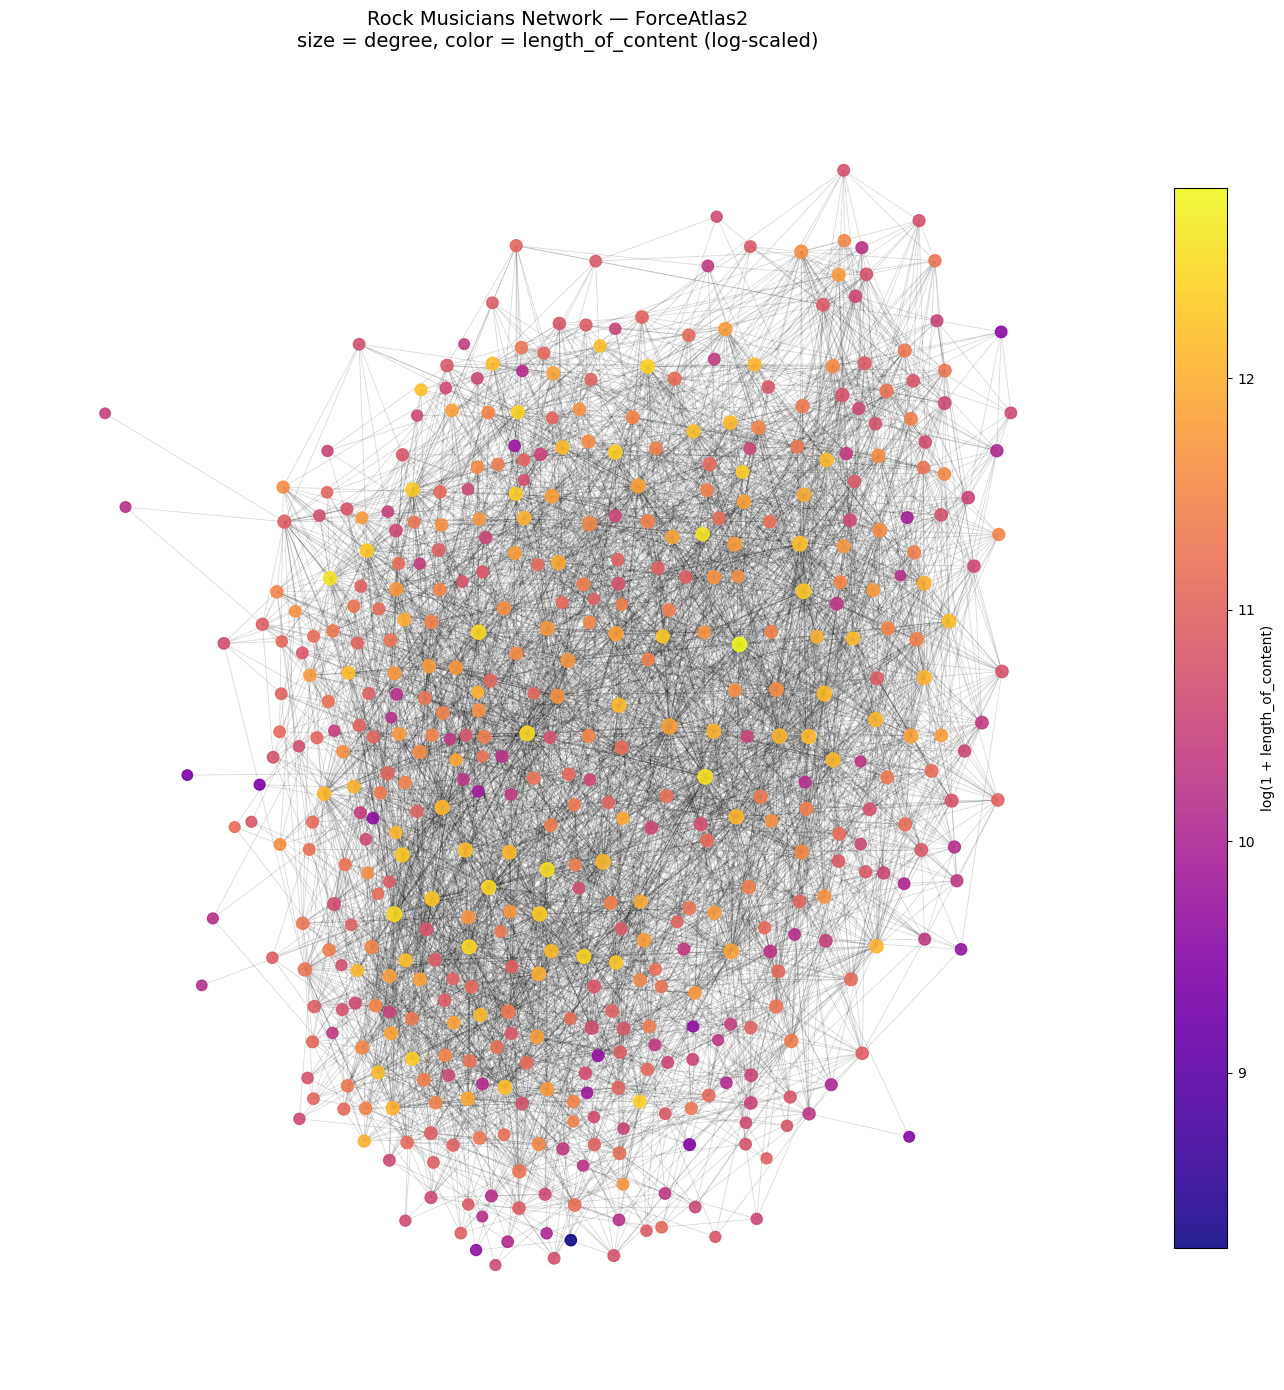

In [2]:
# Exercise 1

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyforceatlas2 import ForceAtlas2

# Convert to undirected graph
G_u = G.to_undirected()

# Extract the Giant Connected Component (GCC)
gcc_nodes = max(nx.connected_components(G_u), key=len)
G_u = G_u.subgraph(gcc_nodes).copy()

# Compute node degree and visualization attributes
deg = np.array([G_u.degree(n) for n in G_u.nodes()])
deg_scaled = 50 + 6 * np.sqrt(deg)

lengths = np.array([G_u.nodes[n]["length_of_content"] for n in G_u.nodes()])
lengths_log = np.log1p(lengths)

# Apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outbound_attraction_distribution=True,
    barnes_hut_optimize=True,
    barnes_hut_theta=1.2,
    scaling_ratio=2.0,
    gravity=0.5,
    verbose=False
)

pos = forceatlas2.forceatlas2_networkx_layout(G_u, pos=None, iterations=1500)

# Plot the network
plt.figure(figsize=(14, 14))
nodes = nx.draw_networkx_nodes(
    G_u, pos,
    node_size=deg_scaled,
    node_color=lengths_log,
    cmap=plt.cm.plasma,
    alpha=0.9
)
nx.draw_networkx_edges(G_u, pos, alpha=0.15, width=0.6)

plt.title("Rock Musicians Network — ForceAtlas2\nsize = degree, color = length_of_content (log-scaled)", fontsize=14)
cb = plt.colorbar(nodes, shrink=0.8)
cb.set_label("log(1 + length_of_content)")
plt.axis("off")
plt.tight_layout()
plt.show()

*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the band/mucisians you identified and their network neighbours? (e.g. did they sing a song together, did one write a song for the other?, etc ...). You don't need to come up with a grand theory of Rock Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia. Answer in your own words.
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high(ish) out-degree and with few incoming connections? If yes, open WikiPages of those bands/mucisians and explain what happens?
> 6. Are there any nodes with high in-degree and few going connections? Again, open the WikiPages corresponding to those nodes and explain what happens?

<div class="alert alert-block alert-info">
For this one, I hope you'll limit your LLM use. It's OK to get help in creating the scatter plot, but use NetworkX on your own to identify nodes, and do your own reading and interpreting of Wiki pages.
</div>

In [3]:
# Question 1
# Top 5 by in-degree
top_in = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 performers by in-degree:")
for name, deg in top_in:
    print(f"{name}: {deg} incoming links")

# Top 5 by out-degree
top_out = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 performers by out-degree:")
for name, deg in top_out:
    print(f"{name}: {deg} outgoing links")

Top 5 performers by in-degree:
Led_Zeppelin: 119 incoming links
Bob_Dylan: 95 incoming links
Queen_(band): 88 incoming links
Metallica: 85 incoming links
David_Bowie: 84 incoming links

Top 5 performers by out-degree:
Alice_in_Chains: 71 outgoing links
Deep_Purple: 69 outgoing links
Black_Sabbath: 59 outgoing links
Def_Leppard: 51 outgoing links
Bryan_Adams: 50 outgoing links


Q1 Answer: Artists with high in-degree, such as Led Zeppelin or Bob Dylan, are mentioned by many others, showing they are influential or well-known.
Those with high out-degree, like Alice in Chains or Deep Purple, tend to mention many other bands, often because of collaborations, tours, or shared members.
In general, high in-degree reflects popularity or influence, while high out-degree shows active connections to others.


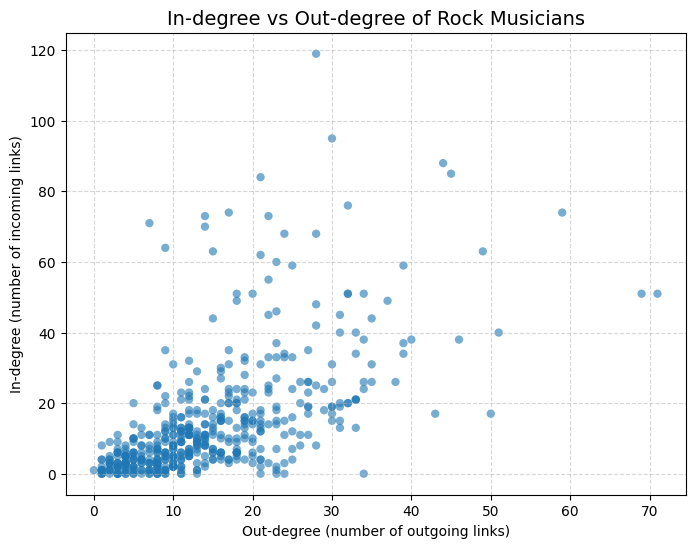

In [4]:
# Question 2
import matplotlib.pyplot as plt

# Calculate in-degree and out-degree for all nodes
in_degrees = [deg for _, deg in G.in_degree()]
out_degrees = [deg for _, deg in G.out_degree()]

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(out_degrees, in_degrees, alpha=0.6, edgecolors='none')

plt.title("In-degree vs Out-degree of Rock Musicians", fontsize=14)
plt.xlabel("Out-degree (number of outgoing links)")
plt.ylabel("In-degree (number of incoming links)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Q2 Anwser: From the scatter plot, most musicians have low in- and out-degree, so they’re not very connected.
A few artists stand out with higher degrees, but there isn’t a strong pattern between the two.
Being well-known doesn’t always mean they link to many others, and those who link to many pages aren’t always the most famous.

In [5]:
# Question 3
high_out_low_in = []
for n in G.nodes():
    in_deg = G.in_degree(n)
    out_deg = G.out_degree(n)
    if out_deg > 20 and in_deg < 10:
        high_out_low_in.append((n, in_deg, out_deg))

high_out_low_in.sort(key=lambda x: x[2], reverse=True)

print(f"Found {len(high_out_low_in)} nodes with high out-degree & few in-links")
for name, indeg, outdeg in high_out_low_in[:10]:
    print(f"{name}: in={indeg}, out={outdeg}")

Found 17 nodes with high out-degree & few in-links
Mötley_Crüe: in=0, out=34
Midnight_Oil: in=8, out=28
Hinder: in=8, out=26
Black_Veil_Brides: in=4, out=25
The_Sweet: in=7, out=25
The_Doobie_Brothers: in=3, out=24
Queensrÿche: in=0, out=24
The_Cult: in=7, out=23
Sam_Fender: in=1, out=23
Blue_Öyster_Cult: in=0, out=23


Q3 Answer: Some artists like Mötley Crüe or Midnight Oil have many outgoing links but few incoming ones.
Their pages mention a lot of other bands, probably collaborations or influences, but others don’t link back to them. These musicians act more like connectors in the network rather than the most famous central figures.

In [6]:
# Quesion 4
high_in_low_out = []
for n in G.nodes():
    in_deg = G.in_degree(n)
    out_deg = G.out_degree(n)
    if in_deg > 20 and out_deg < 10:  
        high_in_low_out.append((n, in_deg, out_deg))

high_in_low_out.sort(key=lambda x: x[1], reverse=True)

print(f"Found {len(high_in_low_out)} nodes with high in-degree & few out-links")
for name, indeg, outdeg in high_in_low_out[:10]:
    print(f"{name}: in={indeg}, out={outdeg}")

Found 6 nodes with high in-degree & few out-links
Elvis_Presley: in=71, out=7
Pink_Floyd: in=64, out=9
Cream_(band): in=35, out=9
ZZ_Top: in=25, out=8
Grateful_Dead: in=25, out=8
Joy_Division: in=22, out=9


Q4 Answer: Bands like Elvis Presley or Pink Floyd have many incoming links but only a few outgoing ones.
They’re the kind of legendary artists that everyone mentions, but their own pages mainly focus on their history instead of linking to others. This shows that a high in-degree usually means fame or influence, not how many links they create themselves.

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

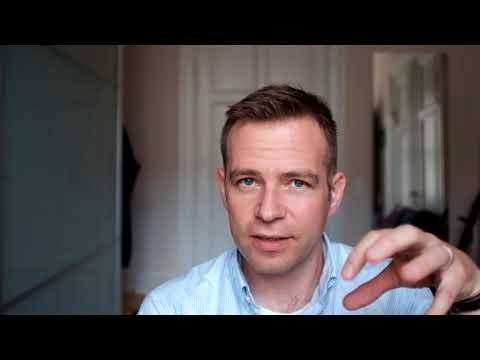

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. Think about what you learned in the book - what does each exponent say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Reflect on the whole power-law thing. Are the degree distributions even power laws? Could a log-normal or exponential distribution be better? How would you find out what the right function to describe the various degree distributions are? 
>    * A long time ago, a group of scientists analyzed the network spanned by **all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

<div class="alert alert-block alert-info">
For this exercise, I also hope you'll limit your LLM use. Especially for the intrepretation parts. It's OK to get help for the heatmap in sub-part 3, maybe also for ideas of how to do the testing in part 5. But do your own interpretation :)
</div>

In [8]:
# Question 1
import numpy as np

# Extract in- and out-degrees
in_degrees = [deg for _, deg in G.in_degree()]
out_degrees = [deg for _, deg in G.out_degree()]

# Compute summary stats
def summarize_degree(degrees, name):
    print(f"\n{name} statistics:")
    print(f"Average: {np.mean(degrees):.2f}")
    print(f"Median: {np.median(degrees):.2f}")
    print(f"Mode: {max(set(degrees), key=degrees.count)}")
    print(f"Minimum: {np.min(degrees)}")
    print(f"Maximum: {np.max(degrees)}")

summarize_degree(in_degrees, "In-degree")
summarize_degree(out_degrees, "Out-degree")


In-degree statistics:
Average: 14.95
Median: 10.00
Mode: 3
Minimum: 0
Maximum: 119

Out-degree statistics:
Average: 14.95
Median: 13.00
Mode: 8
Minimum: 0
Maximum: 71


The average in-degree and out-degree are both around 15, but some nodes have much higher values — up to 119 in-degree and 71 out-degree. This means most musicians only connect to a few others, while a small number of hub artists are linked to many. The difference between the average and the maximum shows that the network is very uneven.

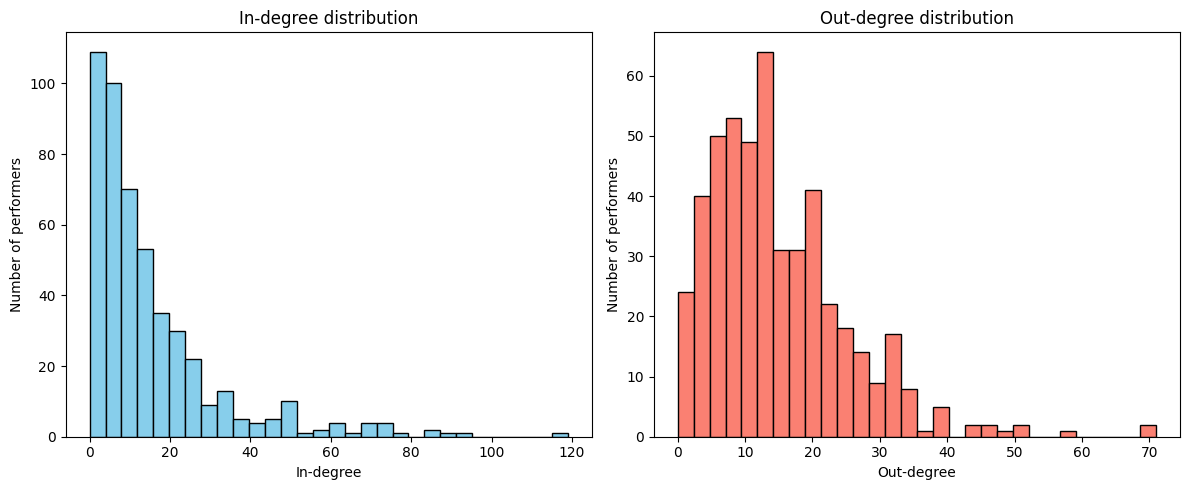

In [9]:
# In/out degree distribution
import matplotlib.pyplot as plt

in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of performers")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=30, color='salmon', edgecolor='black')
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Number of performers")

plt.tight_layout()
plt.show()

In [10]:
import powerlaw

# Fit power law for in- and out-degree
fit_in = powerlaw.Fit(in_degrees)
fit_out = powerlaw.Fit(out_degrees)

print(f"In-degree alpha: {fit_in.alpha:.2f}")
print(f"Out-degree alpha: {fit_out.alpha:.2f}")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree alpha: 2.71
Out-degree alpha: 6.23


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Q2 Answer: When we used the powerlaw package, the in-degree alpha was about 2.7, and the out-degree alpha was around 6.2.
This means the in-degree follows a power-law pretty well — a few famous musicians get many links, while most get only a few. The out-degree, though, drops off too fast and probably fits better with an exponential pattern.
Compared to last week’s plots, this is consistent: the in-degree shows a long tail with some “hub” artists, but the out-degree looks more limited. Overall, our results match earlier Wikipedia studies — the network is partly scale-free, mostly because of the in-degree side.

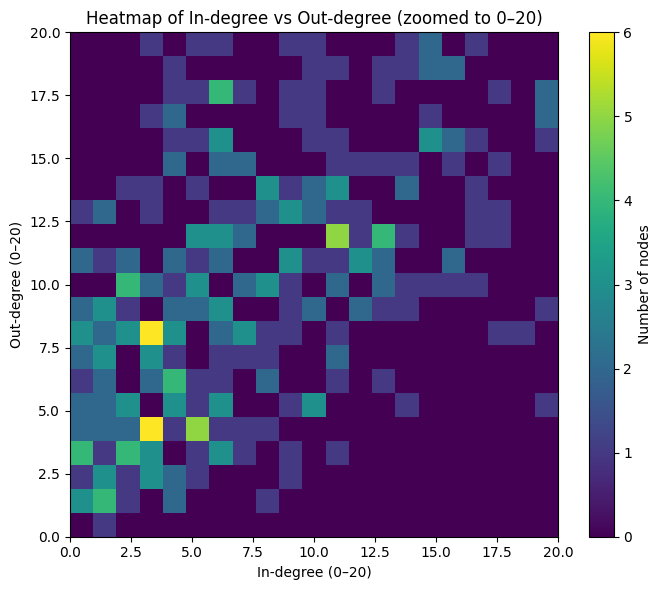

In [11]:
# Question 3

import numpy as np
import matplotlib.pyplot as plt

# Collect (in, out) for every node
pairs = [(G.in_degree(n), G.out_degree(n)) for n in G.nodes()]

# Keep only the zoomed region [0, 20] × [0, 20]
pairs_zoom = [(i, o) for (i, o) in pairs if 0 <= i <= 20 and 0 <= o <= 20]
in_zoom  = [i for i, _ in pairs_zoom]
out_zoom = [o for _, o in pairs_zoom]

# 2D histogram (heatmap)
bins = 21  # 0..20 inclusive → 21 bins
H, xedges, yedges = np.histogram2d(in_zoom, out_zoom,
                                   bins=bins,
                                   range=[[0, 20], [0, 20]])

plt.figure(figsize=(7, 6))
# imshow expects (rows, cols) -> transpose to put x=in, y=out
im = plt.imshow(H.T, origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect='auto')

plt.colorbar(im, label='Number of nodes')
plt.xlabel('In-degree (0–20)')
plt.ylabel('Out-degree (0–20)')
plt.title('Heatmap of In-degree vs Out-degree (zoomed to 0–20)')
plt.grid(False)
plt.tight_layout()
plt.show()

Q3 Answer: The heatmap clearly shows that most nodes are concentrated in the low-degree range (both in-degree and out-degree between 0 and 10).
It’s more useful than the scatter plot because it avoids overlapping points and shows where nodes are most dense.
We can easily see a cluster around in ≈ 5 and out ≈ 5, meaning most musician pages have just a few links in and out.


Q4 Answer: We use a directed graph because links on Wikipedia have direction — one page links to another.
This helps us see who is talked about the most (high in-degree) and who links to many others (high out-degree).
In an undirected graph, we would lose that difference.
But for things like collaborations or band members, the direction doesn’t really matter since the connection goes both ways.

Spearman  length vs out-degree: 0.6724811557963065 p= 2.1877196752780305e-65
Spearman  length vs in-degree : 0.6182871564430173 p= 1.0798742375166983e-52
Pearson   length vs out-degree: 0.6374592850709075 p= 6.815052291276424e-57
Pearson   length vs in-degree : 0.6536703041523384 p= 1.1026157242768187e-60


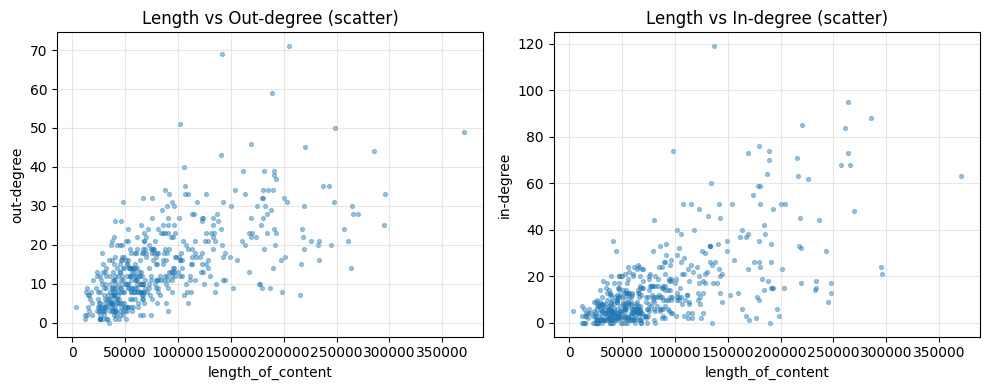

In [12]:
# Question 5
import numpy as np
from scipy.stats import spearmanr, pearsonr

nodes = list(G.nodes())
lengths = np.array([G.nodes[n]["length_of_content"] for n in nodes], dtype=float)
out_deg = np.array([G.out_degree(n) for n in nodes], dtype=float)
in_deg  = np.array([G.in_degree(n) for n in nodes], dtype=float)

# Calculate correlations
sp_len_out = spearmanr(lengths, out_deg, nan_policy="omit")
sp_len_in  = spearmanr(lengths, in_deg,  nan_policy="omit")
pe_len_out = pearsonr(lengths, out_deg)
pe_len_in  = pearsonr(lengths, in_deg)

print("Spearman  length vs out-degree:", sp_len_out.correlation, "p=", sp_len_out.pvalue)
print("Spearman  length vs in-degree :", sp_len_in.correlation,  "p=", sp_len_in.pvalue)
print("Pearson   length vs out-degree:", pe_len_out[0],         "p=", pe_len_out[1])
print("Pearson   length vs in-degree :", pe_len_in[0],          "p=", pe_len_in[1])

# Make simple scatter plots to visualize trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(lengths, out_deg, s=8, alpha=0.4)
plt.xlabel("length_of_content")
plt.ylabel("out-degree")
plt.title("Length vs Out-degree (scatter)")
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(lengths, in_deg, s=8, alpha=0.4)
plt.xlabel("length_of_content")
plt.ylabel("in-degree")
plt.title("Length vs In-degree (scatter)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Q5 Answer: After checking the correlations, both in-degree and out-degree go up with page length. Longer pages usually have more links overall. Out-degree shows a slightly stronger relation — probably because longer articles just contain more text and references, so they link out more often. In-degree is also positive but weaker, meaning long pages are also a bit more “famous” and linked by others.


*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1 (plotting the network). However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

<div class="alert alert-block alert-info">
As in the two previous exercises, I hope you'll limit your LLM use. Try to get a sense of working with NetworkX. And to grow your brain, do your own intrepretation parts ... it's difficult, but that's how you grow.</div>

Top 5 by total degree centrality:
Led_Zeppelin: 0.3025
Black_Sabbath: 0.2737
Queen_(band): 0.2716
Metallica: 0.2675
Bob_Dylan: 0.2572
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


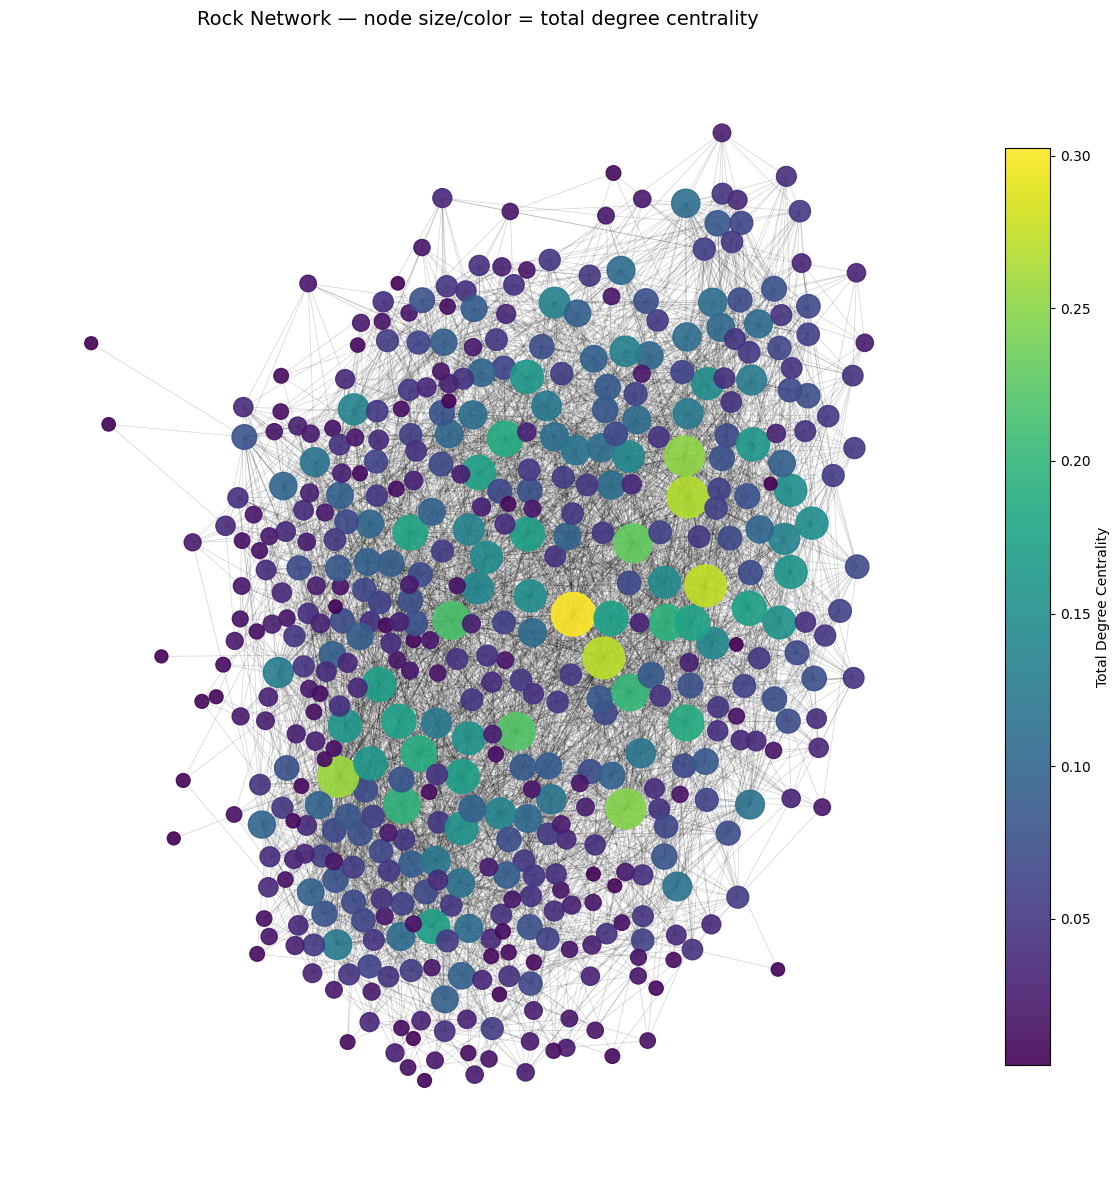

In [23]:
# Question 1: Degree Centrality
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Compute degree centrality 
deg_cent_total = nx.degree_centrality(G)

# Print top 5
top5_total = sorted(deg_cent_total.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by total degree centrality:")
for n, c in top5_total:
    print(f"{n}: {c:.4f}")

# Visualization 
deg_vals = np.array([deg_cent_total.get(n, 0.0) for n in G_u.nodes()])
node_sizes  = 80 + 3000 * deg_vals
node_colors = deg_vals

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_u, pos, alpha=0.15, width=0.6)
nc = nx.draw_networkx_nodes(
    G_u, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.9
)
plt.colorbar(nc, shrink=0.8, label="Total Degree Centrality")
plt.title("Rock Network — node size/color = total degree centrality", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

Top 5 by betweenness centrality:
Deep_Purple: 0.0428
Queen_(band): 0.0397
Alice_in_Chains: 0.0384
Guns_N'_Roses: 0.0365
Jimi_Hendrix: 0.0334


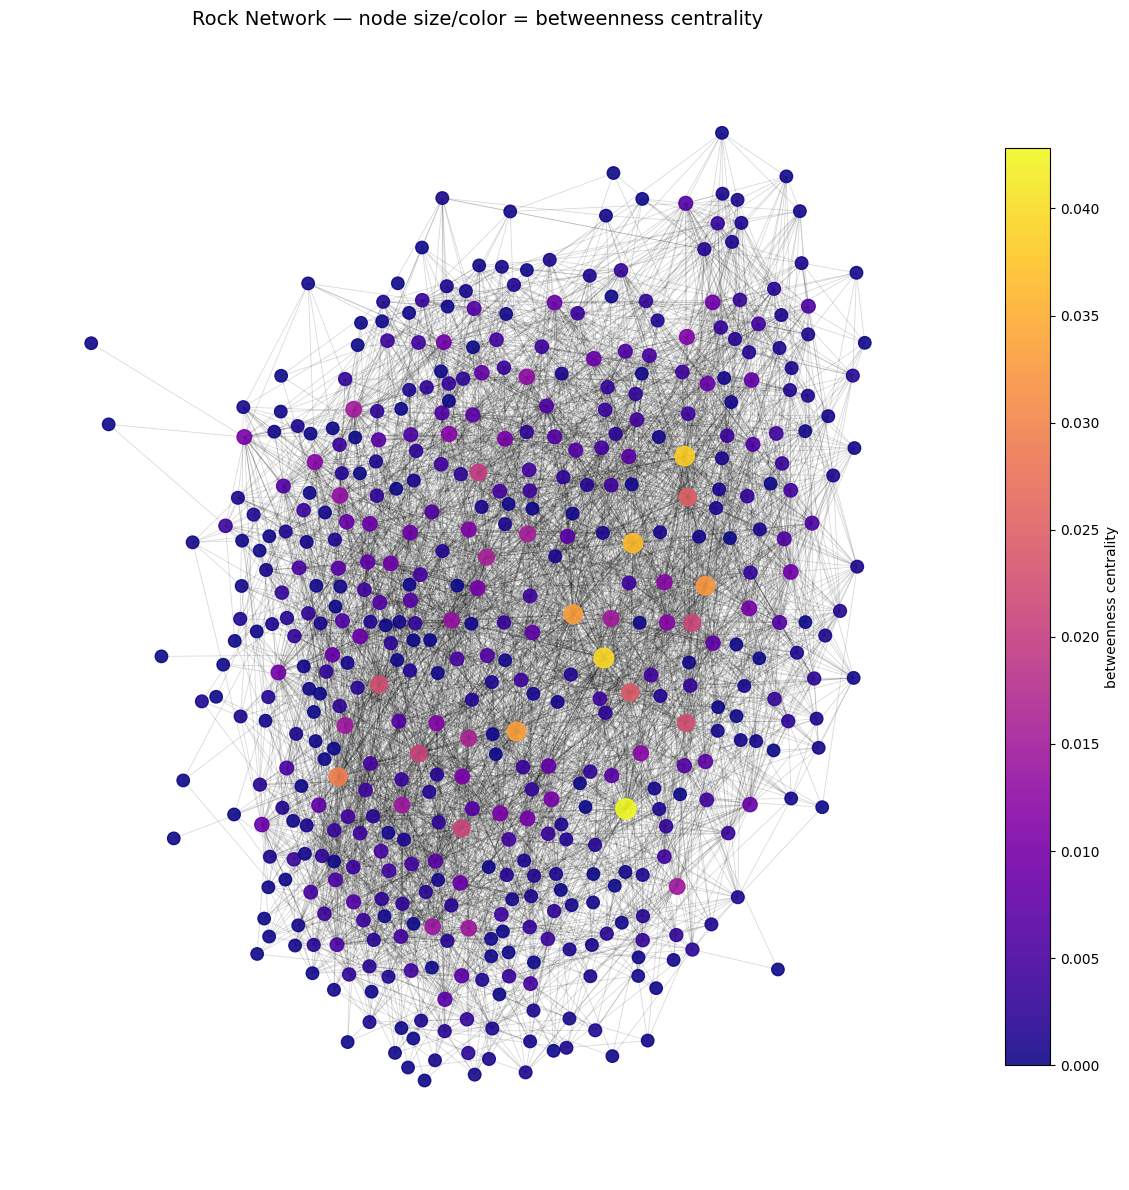

In [14]:
# Question 2 betweenness centrality
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Calculate betweenness
bet = nx.betweenness_centrality(G, normalized=True)

# Print top 5
top5_bet = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by betweenness centrality:")
for n, c in top5_bet:
    print(f"{n}: {c:.4f}")

# Plot 
bvals = np.array([bet.get(n, 0.0) for n in G_u.nodes()])
node_sizes  = 80 + 3000 * bvals
node_colors = bvals

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_u, pos, alpha=0.15, width=0.6)
nc = nx.draw_networkx_nodes(
    G_u, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.plasma,
    alpha=0.9
)
plt.colorbar(nc, shrink=0.8, label="betweenness centrality")
plt.title("Rock Network — node size/color = betweenness centrality", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

Q2 Answer: The artists with high betweenness centrality seem to work as bridges in the network.
They link different parts of the rock music world together. for example, connecting classic rock bands with newer ones.
So they help the network stay connected overall.

Top 5 by OUT-eigenvector centrality:
Led_Zeppelin: 0.2304
Black_Sabbath: 0.1910
Queen_(band): 0.1818
Metallica: 0.1795
David_Bowie: 0.1593

Top 5 by IN-eigenvector centrality:
Alice_in_Chains: 0.2006
Black_Sabbath: 0.1747
Deep_Purple: 0.1671
Metallica: 0.1576
Megadeth: 0.1519


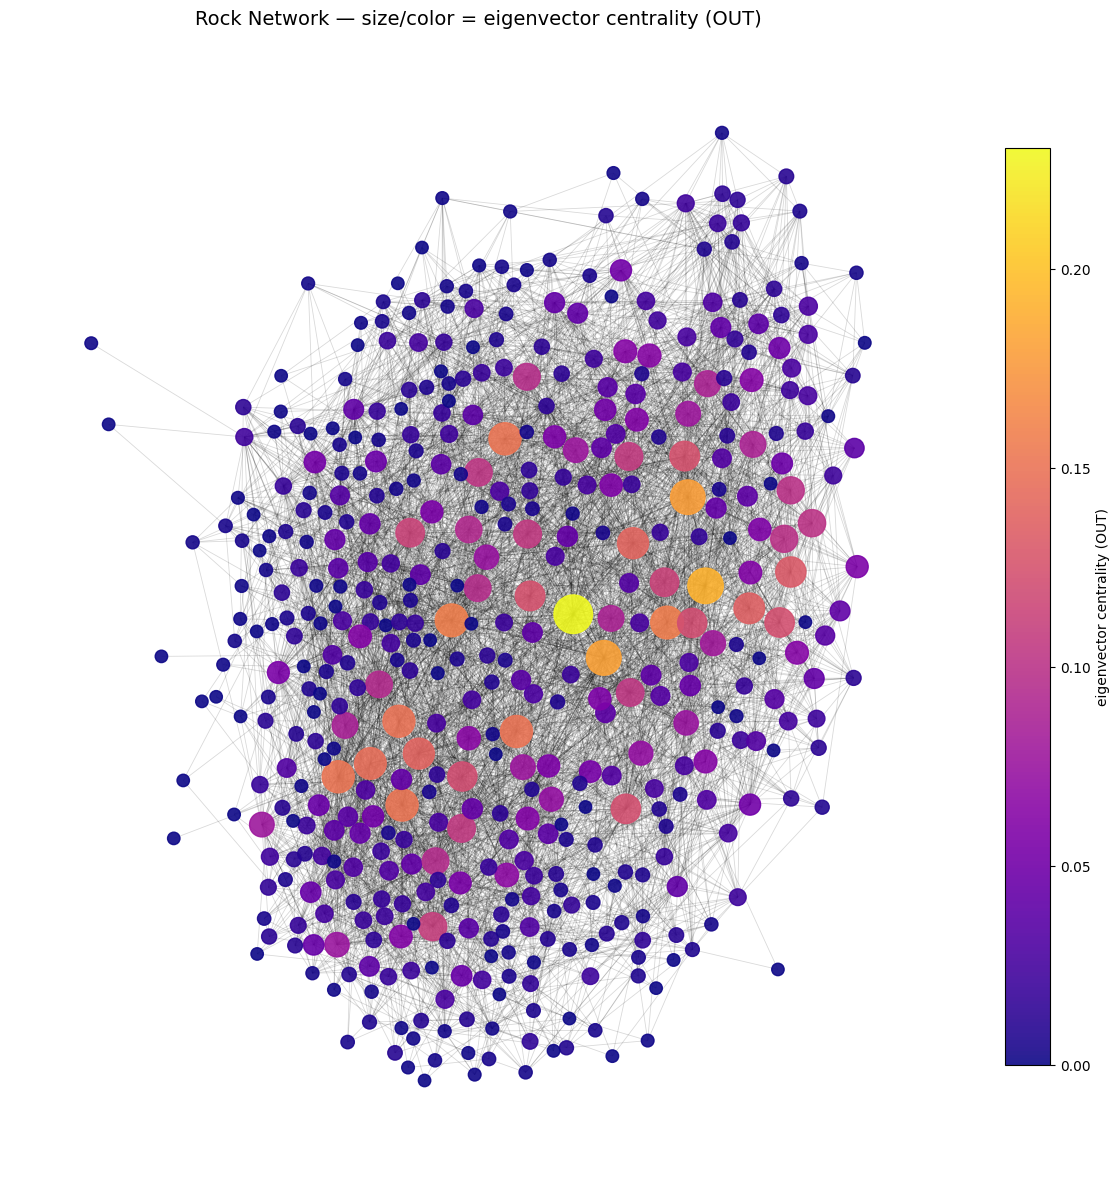

In [15]:
# Question 3 eigenvector centrality 

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Compute out-/in- eigenvector
eig_out = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
eig_in  = nx.eigenvector_centrality(G.reverse(copy=False), max_iter=1000, tol=1e-06)

# Print top 5
def top5(d):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 by OUT-eigenvector centrality:")
for n, c in top5(eig_out):
    print(f"{n}: {c:.4f}")

print("\nTop 5 by IN-eigenvector centrality:")
for n, c in top5(eig_in):
    print(f"{n}: {c:.4f}")

# Plot
vals = np.array([eig_out.get(n, 0.0) for n in G_u.nodes()])
node_sizes  = 80 + 3000 * vals   
node_colors = vals

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_u, pos, alpha=0.15, width=0.6)
nc = nx.draw_networkx_nodes(
    G_u, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.plasma,
    alpha=0.9
)
plt.colorbar(nc, shrink=0.8, label="eigenvector centrality (OUT)")
plt.title("Rock Network — size/color = eigenvector centrality (OUT)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

Q3 Answer: Artists with high eigenvector centrality are usually big, well-known bands that are connected to other famous ones — they sit in the middle of the rock network. Compared to betweenness centrality, which shows musicians that act as bridges between different groups, eigenvector centrality highlights the "core" ones who are part of the main cluster. So basically, betweenness shows the connectors, and eigenvector shows the popular hubs.

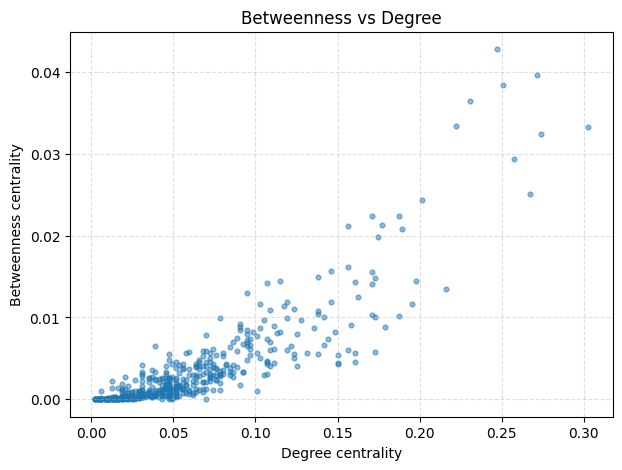

In [16]:
# Question 4 betweenness vs degree

import matplotlib.pyplot as plt
import networkx as nx

deg_cent = nx.degree_centrality(G)         
bet_cent = nx.betweenness_centrality(G)   

x = [deg_cent[n] for n in G.nodes()]
y = [bet_cent[n] for n in G.nodes()]

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=12, alpha=0.5)
plt.xlabel("Degree centrality")
plt.ylabel("Betweenness centrality")
plt.title("Betweenness vs Degree")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

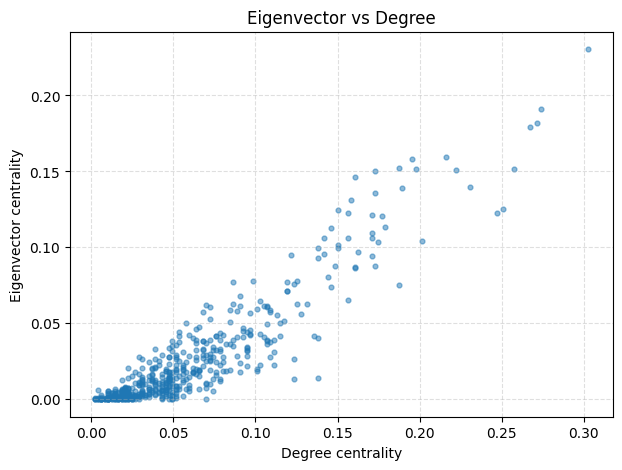

In [17]:
# Question 4 eigenvector vs degree 

eig_cent = nx.eigenvector_centrality(G, max_iter=1000) 

x = [deg_cent[n] for n in G.nodes()]
y = [eig_cent[n] for n in G.nodes()]

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=12, alpha=0.5)
plt.xlabel("Degree centrality")
plt.ylabel("Eigenvector centrality")
plt.title("Eigenvector vs Degree")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

Q4 Answer: There is a clear positive correlation between degree and betweenness — nodes with more links tend to be more central, which makes sense. Still, a few low-degree nodes show high betweenness because they act as bridges between groups. When using eigenvector centrality instead, the trend looks smoother and stronger, as nodes connected to other important ones also get higher scores.

In [18]:
# Question 5

r = nx.degree_assortativity_coefficient(G_u)
print(f"Degree assortativity coefficient: {r:.3f}")

Degree assortativity coefficient: 0.004


Qestion 5 Answer: The assortativity coefficient is about 0.004, which is close to zero. So the network doesn’t really show a clear pattern — high-degree and low-degree musicians connect pretty randomly.

In [19]:
# Question 6

r_attr = nx.attribute_assortativity_coefficient(G_u, "length_of_content")

print(f"attribute_assortativity_coefficient: {r_attr:.3f}")

attribute_assortativity_coefficient: -0.003


Question 6: The assortativity with respect to length_of_content is close to zero (r = –0.003), which means page length has little effect on connections. Long pages often link to short ones, showing that Wikipedia links are quite mixed and not length-based.

[Real] n=487, m=6008, implied p≈0.050769
[Real] average shortest path length: 2.376
[ER]   average shortest path length: 2.226


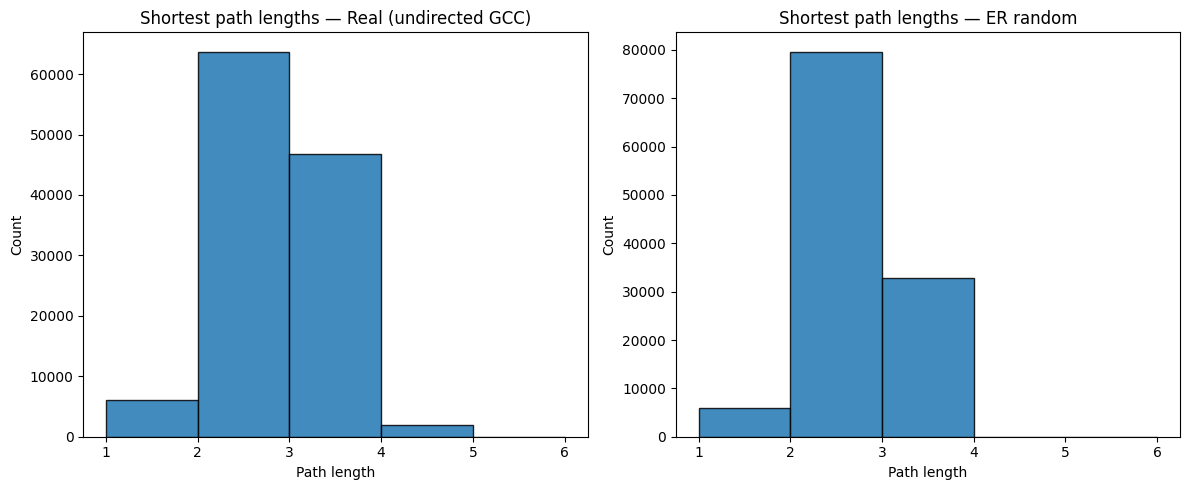

In [20]:
# Questiopn 7
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Basic stats 
n = G_u.number_of_nodes()
m = G_u.number_of_edges()
p = 2 * m / (n * (n - 1)) 
print(f"[Real] n={n}, m={m}, implied p≈{p:.6f}")

# Average shortest path length on the real network
asp_real = nx.average_shortest_path_length(G_u)
print(f"[Real] average shortest path length: {asp_real:.3f}")

# Build a matching ER(n, p) random graph and keep its GCC
seed = 42
G_rand = nx.erdos_renyi_graph(n=n, p=p, seed=seed)
if not nx.is_connected(G_rand):
    gcc_er = max(nx.connected_components(G_rand), key=len)
    G_rand = G_rand.subgraph(gcc_er).copy()

asp_rand = nx.average_shortest_path_length(G_rand)
print(f"[ER]   average shortest path length: {asp_rand:.3f}")

# Collect shortest path lengths 
def unique_pair_lengths(G):
    lengths = []
    nodes = list(G.nodes())
    idx = {u: i for i, u in enumerate(nodes)}
    for u, dist_map in nx.all_pairs_shortest_path_length(G):
        iu = idx[u]
        for v, d in dist_map.items():
            if d > 0 and iu < idx[v]:   # count each undirected pair once
                lengths.append(d)
    return lengths

dist_real = unique_pair_lengths(G_u)
dist_er   = unique_pair_lengths(G_rand)

# Plot
max_len = max(max(dist_real), max(dist_er))
bins = np.arange(1, int(max_len) + 2)  # 1,2,3,...,max_len

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dist_real, bins=bins, edgecolor='black', alpha=0.85)
plt.title("Shortest path lengths — Real (undirected GCC)")
plt.xlabel("Path length"); plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(dist_er, bins=bins, edgecolor='black', alpha=0.85)
plt.title("Shortest path lengths — ER random")
plt.xlabel("Path length"); plt.ylabel("Count")

plt.tight_layout()
plt.show()

Question 7: For the undirected network, the average shortest path length is 2.376, which is close to the random graph’s 2.226. This means our network has small-world characteristics — most nodes are only two or three steps apart.
The histogram shows that both graphs have short path lengths, but the real network’s distribution is a bit wider, suggesting more local clusters or communities compared to the random network.


# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also called the "disparity filter". I explain what it's all about in the video below.

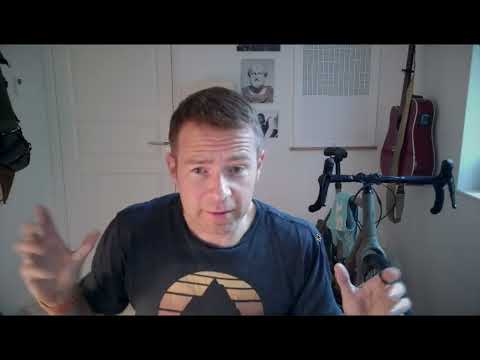

In [21]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

There are [many backbone extraction algorithms](https://www.michelecoscia.com/?page_id=287), and I've chosen to talk about the *Disparity Filter* here, because it's the oldest and most commonly used method (so I though you should know about it). Plus, it'll probably be the relevant method for your project.

This choice, however, presents us with a problem: As I explain in the video, the Disparity Filter method *only works on weighted networks*. But our network does not have edge weights in any kind of natural way (since there's usually just a single link between two wiki pages). 


So to get rid of unimportant edges, we'll have to try something different. I present you with three possible methods below. For the first two ones, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for *edges* instead of nodes.

We can create two new weighted networks based on the edge betweenness
 * **Weighted Network 1**: The ***undirected*** Rock Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Rock Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

The third strategy (resulting in **Weighted network 3**) is to use a method designed for extracting structure from undirected networks: The [**High-Salience Skeleton**](https://www.nature.com/articles/ncomms1847). It's implemented as part of [this backbone extraction package](https://www.michelecoscia.com/?page_id=287)


Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1, 2, and 3. You can implement the disparity filter yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting three networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the three networks. Describe your findings in your own words.
>    * Weighted network 1, 2, and 3 are very different. In 1 and 2, we have removed edges with low/high edge betweenness centrality respectively and HSH is based on shortest paths. What have the various filters done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structures.

<div class="alert alert-block alert-info">
There's a lot to do today, so knock youself out with your LLM for this exercise, hopefully it can make your life easier (although I hope you'll do a bit of your own thinking, since a lot of complicated conceptual things are going on with the interplay between the backboning and edge betweenness and inverse edge betweenness!)</div>

One final thing. For now, the backbones are mostly for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear because I've made up two of the methods. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.


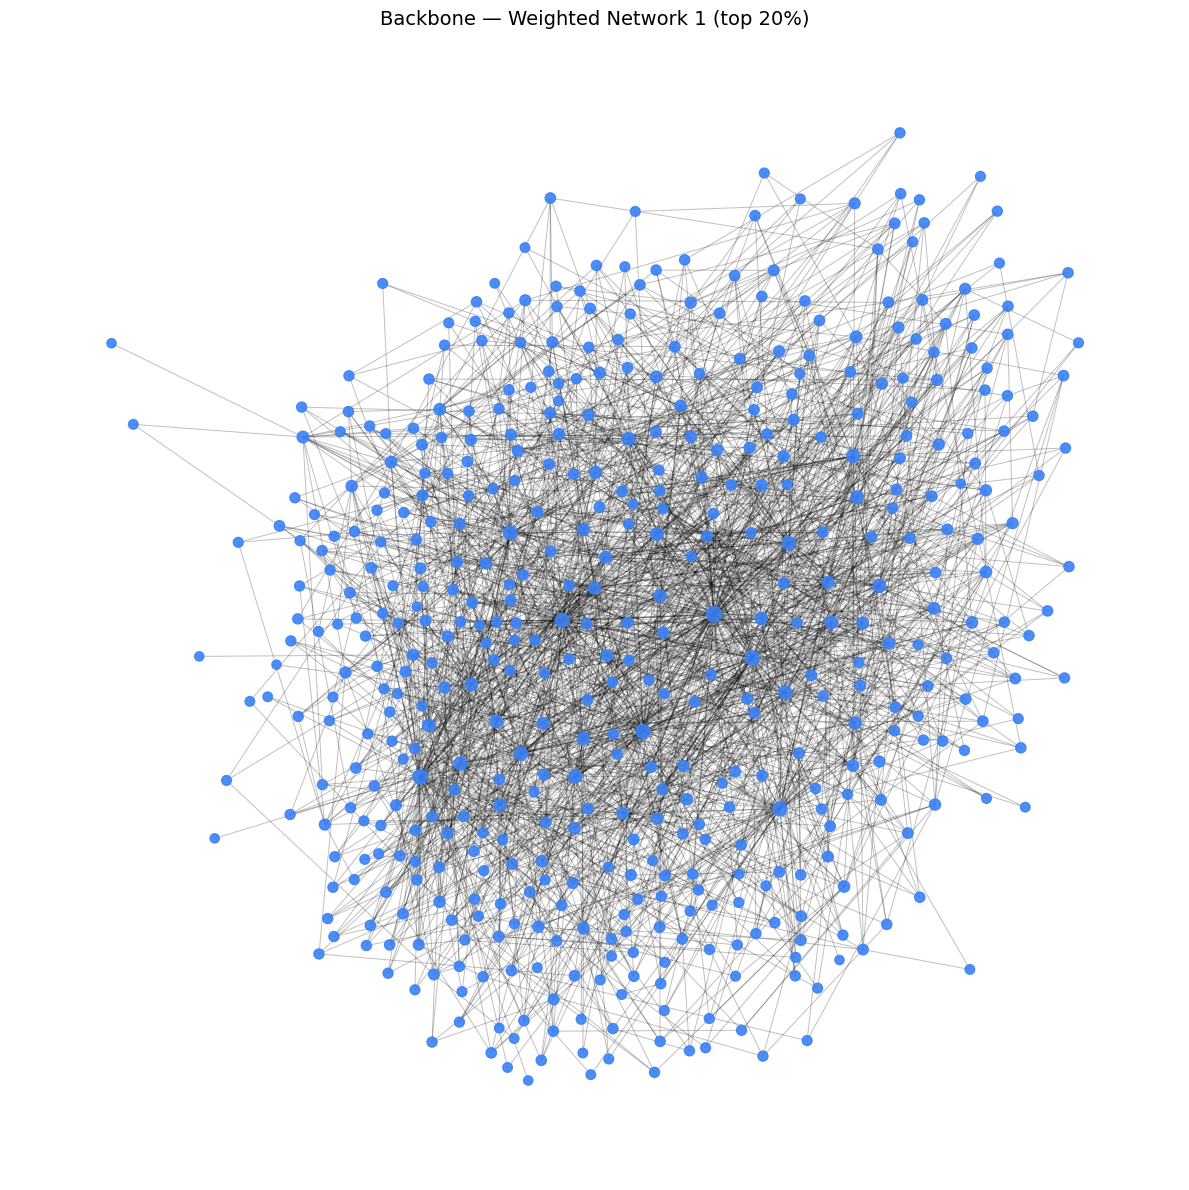

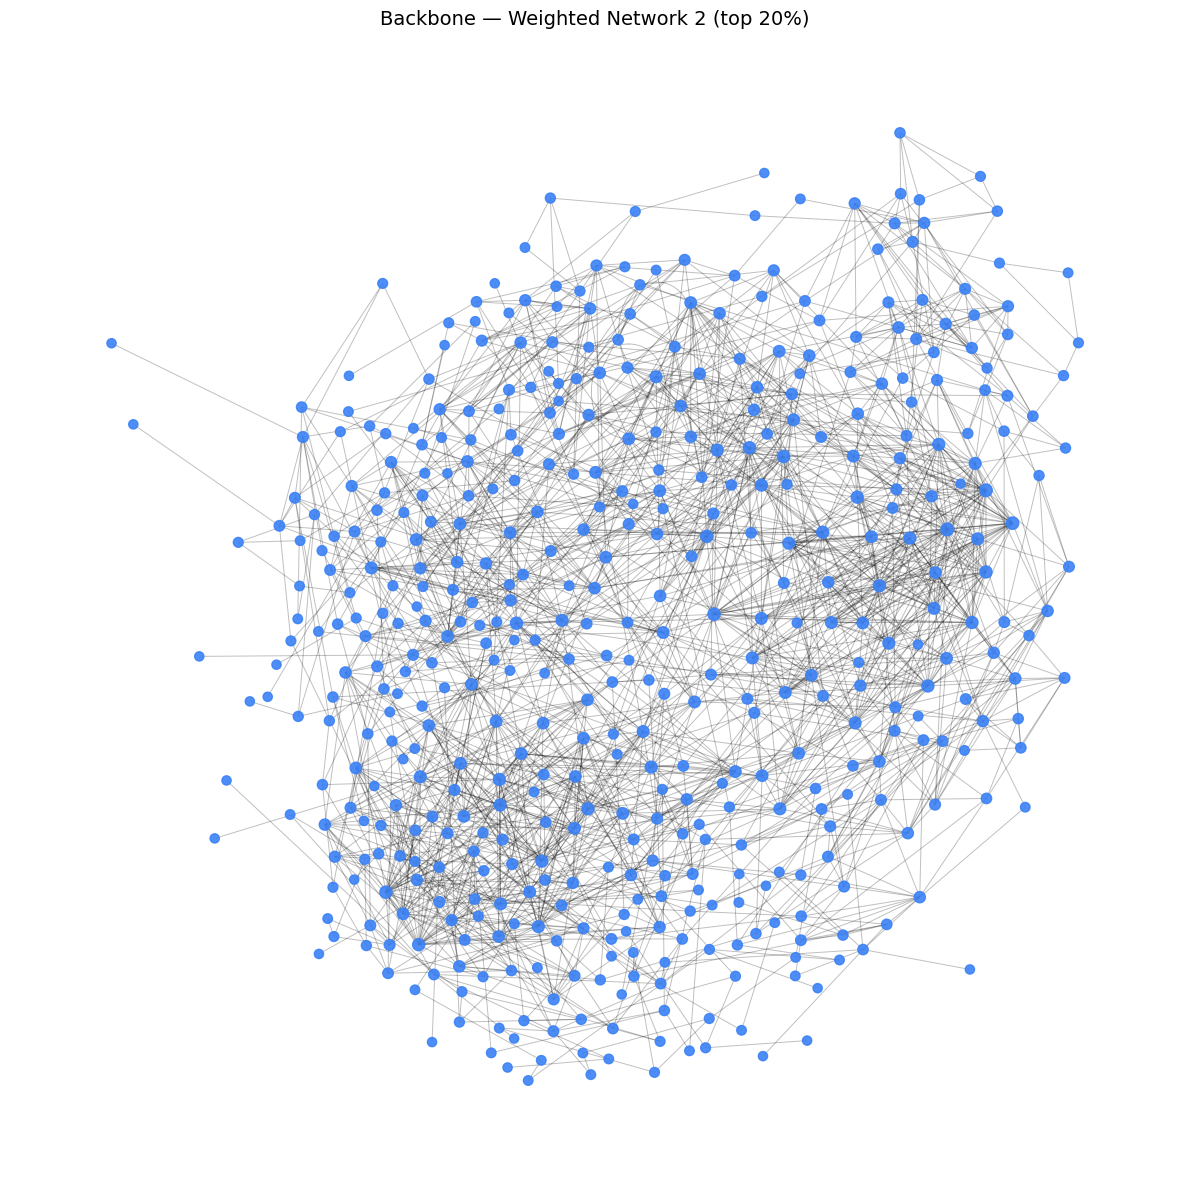

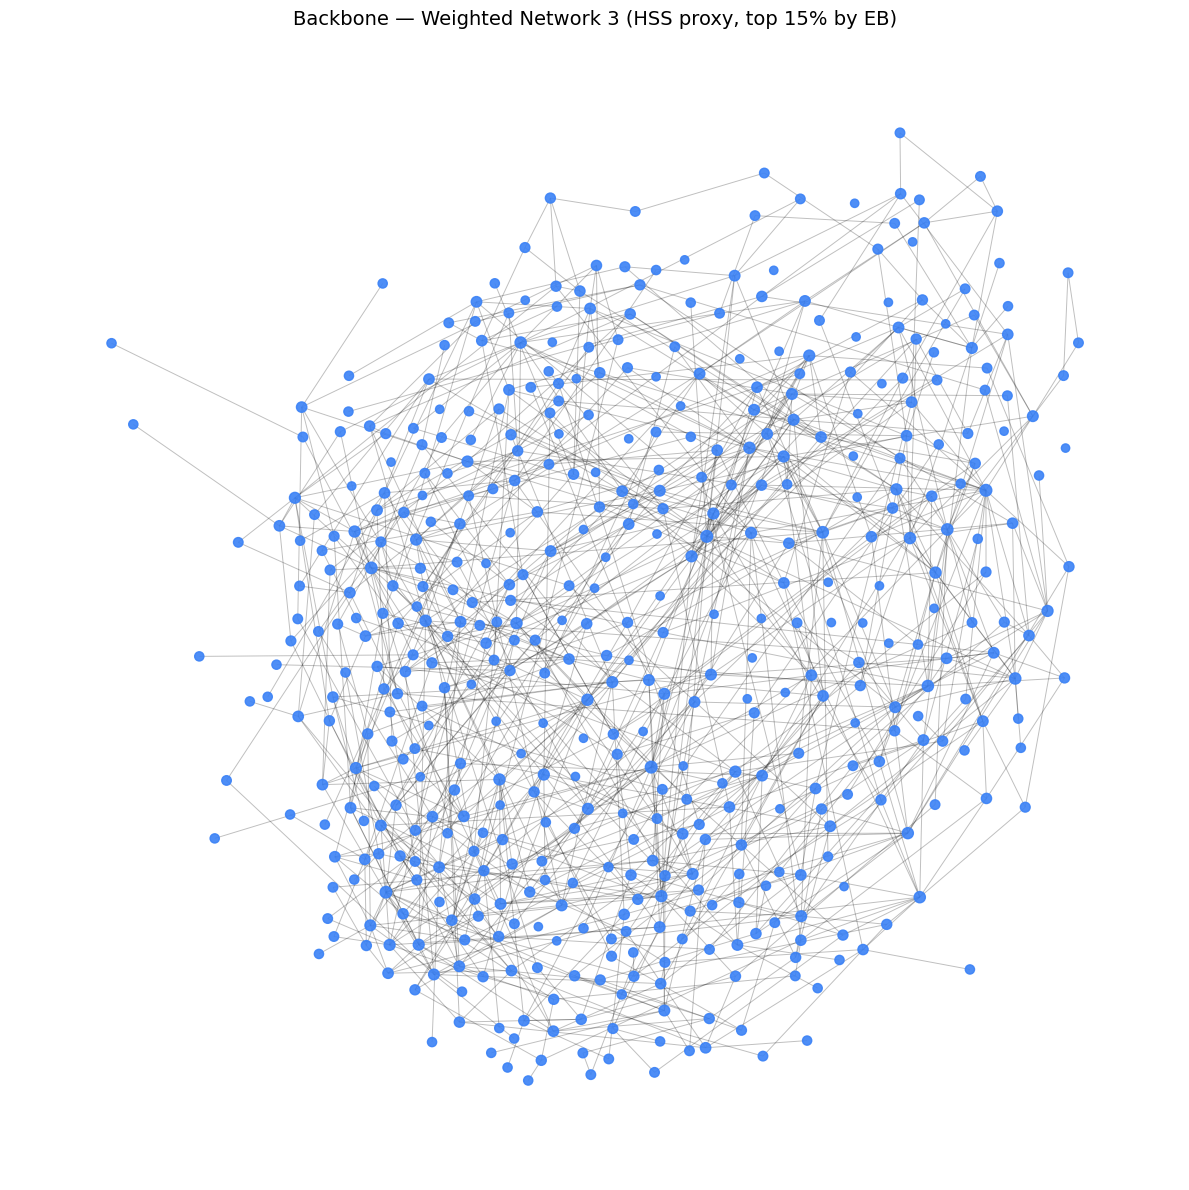

In [22]:
# Exercise 5

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def minmax_rescale(arr, a=1.0, b=100.0):
    arr = np.asarray(arr, dtype=float)
    lo, hi = arr.min(), arr.max()
    if hi == lo:
        return np.full_like(arr, a)
    return a + (b - a) * (arr - lo) / (hi - lo)

def build_graph_with_weights(G_base, weight_dict):
    """Return a new Graph with the same nodes and weighted edges from weight_dict."""
    H = nx.Graph()
    H.add_nodes_from(G_base.nodes())
    for (u, v), w in weight_dict.items():
        if H.has_edge(u, v):
            # if multi-edges somehow appeared, keep the max
            H[u][v]['weight'] = max(H[u][v]['weight'], float(w))
        else:
            H.add_edge(u, v, weight=float(w))
    return H

def pernode_top_fraction_backbone(Gw, top_frac=0.20):
    """
    Keep an edge if it is among the top-fraction (by normalized share p_ij = w_ij/s_i)
    of incident edges at node u OR at node v.
    This preserves locally-significant ties and avoids over-pruning.
    """
    B = nx.Graph()
    B.add_nodes_from(Gw.nodes())

    # Precompute strength and normalized shares
    strengths = {n: sum(d.get("weight", 1.0) for _, _, d in Gw.edges(n, data=True)) for n in Gw.nodes()}
    nbr_shares = {}
    for n in Gw.nodes():
        s = strengths[n]
        if s <= 0.0:
            nbr_shares[n] = {}
            continue
        shares = {}
        for nbr, d in Gw[n].items():
            w = d.get("weight", 1.0)
            shares[nbr] = w / s
        # sort neighbors by share desc
        sorted_nbrs = sorted(shares.items(), key=lambda x: x[1], reverse=True)
        k = len(sorted_nbrs)
        keep_k = max(1, int(np.ceil(top_frac * k)))  # keep at least 1
        nbr_shares[n] = {nbr for nbr, _ in sorted_nbrs[:keep_k]}

    # keep edge if it's in top list of either endpoint
    for u, v, d in Gw.edges(data=True):
        if (v in nbr_shares.get(u, set())) or (u in nbr_shares.get(v, set())):
            B.add_edge(u, v, **d)
    return B

def draw_backbone(Gb, pos, title):
    deg = np.array([Gb.degree(n) for n in Gb.nodes()])
    sizes = 36 + 8 * np.sqrt(deg)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(Gb, pos, alpha=0.25, width=0.7)
    nx.draw_networkx_nodes(Gb, pos, node_size=sizes, node_color="#3B82F6", alpha=0.9)
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

#  W1: weight = edge betweenness (rescaled to [1,100]) 

# unweighted betweenness on the undirected network (as the assignment suggests)
eb_raw = nx.edge_betweenness_centrality(G_u, normalized=True)
w1_vals = minmax_rescale(np.array(list(eb_raw.values())), 1.0, 100.0)
w1_dict = {e: float(w) for e, w in zip(eb_raw.keys(), w1_vals)}
W1 = build_graph_with_weights(G_u, w1_dict)

# W2: weight = 1 / W1_weight, then rescale again to [1,100] 

w2_inv = np.array([1.0 / w for w in w1_vals])
w2_vals = minmax_rescale(w2_inv, 1.0, 100.0)  # re-scale to keep numerics sane
w2_dict = {e: float(w) for e, w in zip(eb_raw.keys(), w2_vals)}
W2 = build_graph_with_weights(G_u, w2_dict)

# Backbones 
# Use per-node top-fraction backbone (locally significant ties)
TOP_FRAC = 0.20  # try 0.15 ~ 0.30 depending on how sparse you want

BB1 = pernode_top_fraction_backbone(W1, top_frac=TOP_FRAC)
BB2 = pernode_top_fraction_backbone(W2, top_frac=TOP_FRAC)

# HSS proxy = keep top-q edges by global edge betweenness (on W1)
KEEP_TOP = 0.15  # 10%~25% are common choices
eb_w1 = nx.edge_betweenness_centrality(W1, normalized=True, weight="weight")
sorted_edges = sorted(eb_w1.items(), key=lambda x: x[1], reverse=True)
k_top = max(1, int(len(sorted_edges) * KEEP_TOP))
keep_set = {e for e, _ in sorted_edges[:k_top]}

BB3 = nx.Graph()
BB3.add_nodes_from(W1.nodes())
for u, v, d in W1.edges(data=True):
    if (u, v) in keep_set or (v, u) in keep_set:
        BB3.add_edge(u, v, **d)

# Plot
draw_backbone(BB1, pos, f"Backbone — Weighted Network 1 (top {int(TOP_FRAC*100)}%)")
draw_backbone(BB2, pos, f"Backbone — Weighted Network 2 (top {int(TOP_FRAC*100)}%)")
draw_backbone(BB3, pos, f"Backbone — Weighted Network 3 (HSS proxy, top {int(KEEP_TOP*100)}% by EB)")

Answer: The three backbone networks look quite different. In W1, where edge weights come from betweenness, the network keeps many global links — it still looks dense in the center, showing the main “roads” that connect different groups.
In W2, where weights are based on 1/betweenness, the result is more clustered — mostly local links remain inside communities, and long bridges are gone. The W3 (HSS proxy) version sits between the two: it’s cleaner and shows the key structure without too many edges. Overall, W1 shows the global backbone, W2 highlights local clusters, and W3 gives a good balance between the two.
